<a href="https://colab.research.google.com/github/abegpatel/energy-data-forecasting-with-a-multivariate-tseries-model/blob/master/multivariate_RNN_Tser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/energydata_complete.csv',index_col='date',parse_dates=True)


In [ ]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

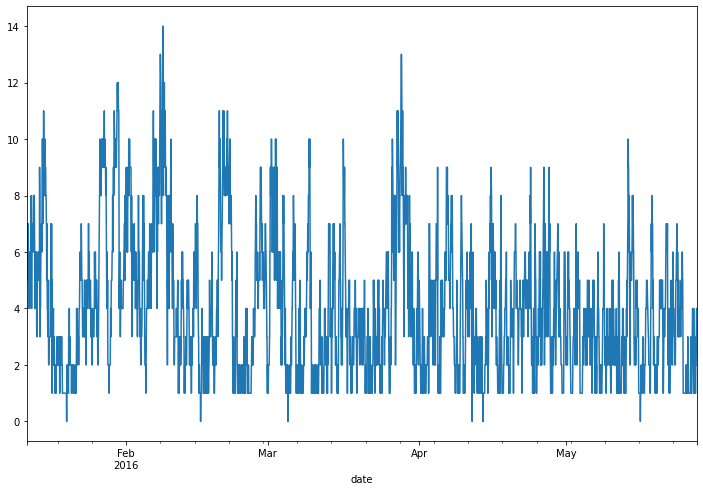

In [ ]:
df['Windspeed'].plot(figsize=(12,8))

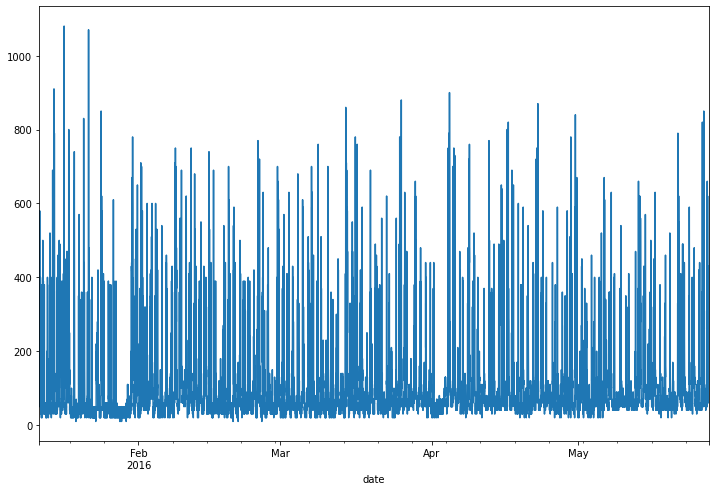

In [ ]:
df['Appliances'].plot(figsize=(12,8))

**Train Test Split**

In [ ]:
len(df)

19735

In [ ]:
df.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


In [ ]:
df.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


*Let's imagine we want to predict just 24 hours into the future, we don't need 3 months of data for that, so let's save some training time and only select the last months data.*

In [ ]:
df = df.loc['2016-05-01':]

In [ ]:
df = df.round(2)

In [ ]:
len(df)

3853

In [ ]:
# How many rows per day? We know its every 10 min
24*60/10

144.0

In [ ]:
test_days = 2

In [ ]:
test_ind = test_days*144

In [ ]:
test_ind

288

In [ ]:
# Notice the minus sign in our indexing

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [ ]:
train

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.20,38.20,18.39,41.40,23.20,36.40,19.73,37.73,19.50,47.29,4.80,40.06,19.50,31.60,22.20,40.00,19.17,38.20,4.30,763.70,86.00,2.00,40.00,2.20,15.31,15.31
2016-05-01 00:10:00,60,0,21.15,38.17,18.39,41.50,23.13,36.47,19.70,37.66,19.50,47.29,4.80,40.09,19.50,31.60,22.20,40.40,19.13,38.29,4.28,763.72,86.33,2.17,38.17,2.22,11.24,11.24
2016-05-01 00:20:00,50,0,21.13,38.09,18.32,41.50,23.20,36.50,19.70,37.59,19.50,47.26,4.66,40.03,19.50,31.60,22.20,41.00,19.13,38.36,4.27,763.73,86.67,2.33,36.33,2.23,21.81,21.81
2016-05-01 00:30:00,50,0,21.10,38.09,18.29,41.50,23.20,36.50,19.70,37.50,19.50,47.26,4.53,41.30,19.50,31.60,22.20,41.33,19.17,38.50,4.25,763.75,87.00,2.50,34.50,2.25,47.00,47.00
2016-05-01 00:40:00,60,0,21.10,38.03,18.29,41.56,23.20,36.50,19.70,37.50,19.50,47.20,4.59,41.83,19.50,31.60,22.20,41.63,19.17,38.63,4.23,763.77,87.33,2.67,32.67,2.27,8.06,8.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-25 17:20:00,120,0,24.50,37.22,24.13,34.30,25.20,37.64,24.36,38.29,20.85,51.59,19.57,1.00,23.24,34.29,24.50,38.97,21.89,37.03,16.17,756.17,52.67,1.33,31.33,6.43,33.46,33.46
2016-05-25 17:30:00,190,0,24.50,37.16,24.10,34.30,25.20,37.55,24.29,38.16,20.89,51.59,19.26,1.00,23.20,34.29,24.39,38.79,21.89,37.20,16.25,756.15,53.50,1.50,33.50,6.75,0.43,0.43
2016-05-25 17:40:00,160,0,24.50,37.43,24.10,34.43,25.14,37.28,24.29,38.00,21.00,51.59,19.20,1.00,23.25,34.45,24.39,38.74,21.89,37.33,16.33,756.13,54.33,1.67,35.67,7.07,16.67,16.67


In [ ]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


**Scale Data**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

**Time Series Generator**

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
length = 144 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [ ]:
len(scaled_train)

3565

In [ ]:
len(generator) 

3421

In [ ]:
# What does the first batch look like?
X,y = generator[0]

In [ ]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]
Predict this y: 
 [[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


**### Create the Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [ ]:
scaled_train.shape

(3565, 28)

In [ ]:
# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               51600     
_________________________________________________________________
dense (Dense)                (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


**EarlyStopping**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

In [ ]:
model.fit_generator(generator,epochs=10,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/10
3421/3421 [==============================] - 165s 48ms/step - loss: 0.0073 - val_loss: 0.0079
Epoch 2/10
3421/3421 [==============================] - 156s 46ms/step - loss: 0.0072 - val_loss: 0.0081


In [ ]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

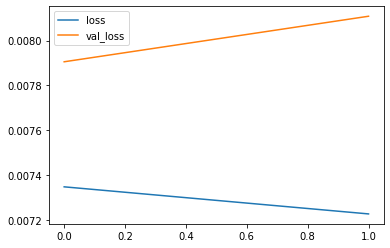

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

**Evaluate on Test Data¶**

In [ ]:
first_eval_batch = scaled_train[-length:]

In [ ]:
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [ ]:
model.predict(first_eval_batch)

array([[0.13204247, 0.08193678, 0.6967405 , 0.38214692, 0.53269917,
        0.4462423 , 0.39531597, 0.43153313, 0.7004763 , 0.3952314 ,
        0.30417958, 0.445971  , 0.6640381 , 0.01727636, 0.6384674 ,
        0.39289868, 0.518634  , 0.3401784 , 0.5495421 , 0.34352332,
        0.5979965 , 0.5400009 , 0.44566256, 0.22750045, 0.589872  ,
        0.5409091 , 0.508163  , 0.51134086]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

In [ ]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(432):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

[array([0.13204247, 0.08193678, 0.6967405 , 0.38214692, 0.53269917,
        0.4462423 , 0.39531597, 0.43153313, 0.7004763 , 0.3952314 ,
        0.30417958, 0.445971  , 0.6640381 , 0.01727636, 0.6384674 ,
        0.39289868, 0.518634  , 0.3401784 , 0.5495421 , 0.34352332,
        0.5979965 , 0.5400009 , 0.44566256, 0.22750045, 0.589872  ,
        0.5409091 , 0.508163  , 0.51134086], dtype=float32),
 array([0.14348868, 0.12528935, 0.69079286, 0.37987593, 0.5225336 ,
        0.45067117, 0.3746029 , 0.43065336, 0.6878052 , 0.38867328,
        0.33116347, 0.54904073, 0.6526111 , 0.02019054, 0.636703  ,
        0.3902792 , 0.5195819 , 0.35309458, 0.55013216, 0.33106613,
        0.59216356, 0.5501838 , 0.45633805, 0.2488981 , 0.58473766,
        0.5447086 , 0.51968616, 0.51531947], dtype=float32),
 array([0.1427117 , 0.15176874, 0.6832574 , 0.3785426 , 0.51350695,
        0.4556024 , 0.35465795, 0.42945617, 0.6779188 , 0.38578773,
        0.35635823, 0.65888304, 0.6388149 , 0.02367753, 0.6326

In [ ]:
scaled_test

array([[0.19480519, 0.        , 0.70017036, ..., 0.53372781, 0.76305783,
        0.76305783],
       [0.37662338, 0.        , 0.70017036, ..., 0.52840237, 0.62337402,
        0.62337402],
       [0.12987013, 0.        , 0.70017036, ..., 0.52366864, 0.08785271,
        0.08785271],
       ...,
       [0.32467532, 0.33333333, 0.87052811, ..., 0.86804734, 0.58415049,
        0.58415049],
       [0.51948052, 0.33333333, 0.87052811, ..., 0.86568047, 0.12627577,
        0.12627577],
       [0.53246753, 0.33333333, 0.87052811, ..., 0.86390533, 0.68260957,
        0.68260957]])

**Inverse Transformations and Compare**

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
true_predictions

array([[ 121.67270005,    2.45810352,   24.47986678, ...,    7.74136398,
          25.40290388,   25.5617026 ],
       [ 130.48628002,    3.75868052,   24.44495408, ...,    7.8055755 ,
          25.97871754,   25.76051375],
       [ 129.88800824,    4.55306232,   24.40072094, ...,    7.82830464,
          26.61596757,   26.32320736],
       ...,
       [-231.47824824,    0.9392963 ,   20.68172067, ...,   14.75903666,
          34.85169313,   35.41067858],
       [-231.47829413,    0.93929663,   20.68171964, ...,   14.75903465,
          34.85169611,   35.41067561],
       [-231.47827119,    0.93929596,   20.68171953, ...,   14.75903263,
          34.85169313,   35.41067561]])

In [ ]:
test

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,21.20,51.37,19.32,1.00,23.29,34.70,24.39,39.13,22.00,37.23,16.48,756.1,55.83,2.00,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,21.29,51.14,19.39,1.00,23.32,34.76,24.41,39.62,22.00,37.36,16.47,756.1,55.67,2.00,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,21.32,50.73,19.43,1.00,23.36,34.94,24.50,40.34,22.03,37.39,16.45,756.1,55.50,2.00,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,21.39,50.35,19.36,1.00,23.39,35.00,24.55,40.54,22.10,37.72,16.43,756.1,55.33,2.00,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,21.39,50.35,19.25,1.66,23.39,35.05,24.54,40.59,22.10,37.81,16.42,756.1,55.17,2.00,30.83,7.28,10.27,10.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,25.57,46.56,25.89,42.03,27.20,41.16,24.70,45.59,23.20,52.40,24.80,1.00,24.50,44.50,24.70,50.07,23.20,46.79,22.73,755.2,55.67,3.33,23.67,13.33,43.10,43.10
2016-05-27 17:30:00,90,0,25.50,46.50,25.75,42.08,27.13,41.22,24.70,45.59,23.23,52.33,24.20,1.00,24.56,44.41,24.70,49.79,23.20,46.79,22.60,755.2,56.00,3.50,24.50,13.30,49.28,49.28
2016-05-27 17:40:00,270,10,25.50,46.60,25.63,42.77,27.05,41.69,24.70,45.73,23.23,52.27,23.63,1.00,24.54,44.40,24.70,49.66,23.20,46.79,22.47,755.2,56.33,3.67,25.33,13.27,29.20,29.20


In [ ]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [ ]:
true_predictions

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,121.672700,2.458104,24.479867,37.586362,24.032759,35.467129,24.922556,36.934607,24.103334,37.430900,21.179752,56.190266,19.219029,1.998401,23.480118,34.575581,24.404382,39.382023,22.067527,37.301021,16.291114,756.412021,57.870354,2.275005,40.392320,7.741364,25.402904,25.561703
1,130.486280,3.758681,24.444954,37.523569,23.905994,35.616071,24.774665,36.917962,24.014636,37.286359,21.358925,62.284779,18.910499,2.166811,23.467820,34.516407,24.409946,39.687749,22.070714,37.030824,16.148791,756.644190,58.681692,2.488981,40.084260,7.805576,25.978718,25.760514
2,129.888008,4.553062,24.400721,37.486703,23.793432,35.781909,24.632258,36.895311,23.945432,37.222761,21.526219,68.779754,18.538003,2.368324,23.439514,34.552121,24.419104,39.974675,22.050493,36.749850,15.948953,756.821057,59.391590,2.717363,39.404173,7.828305,26.615968,26.323207
3,127.673638,4.914344,24.341290,37.497558,23.678821,35.923098,24.496995,36.850866,23.865532,37.215059,21.679899,75.166001,18.136497,2.642090,23.374307,34.575787,24.406958,40.240866,22.014474,36.459419,15.727383,756.997972,60.199276,2.950322,38.628778,7.845496,27.186468,26.834002
4,124.460833,5.028759,24.267885,37.581245,23.578647,36.095099,24.360703,36.792551,23.782393,37.270251,21.814168,81.264545,17.735223,3.003116,23.289756,34.582502,24.372767,40.503127,21.976147,36.175299,15.508692,757.216034,61.188423,3.181085,37.868183,7.880237,27.741197,27.360957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,-231.478340,0.939296,20.681720,42.593505,17.595662,49.662367,21.403127,40.447763,22.354577,41.065871,26.270017,128.012170,-1.963563,96.017372,23.490211,52.240887,20.265982,55.822772,22.441548,53.047633,13.119134,779.688280,103.067920,-0.691435,74.029968,14.759035,34.851702,35.410676
428,-231.478294,0.939296,20.681720,42.593505,17.595662,49.662365,21.403127,40.447760,22.354577,41.065869,26.270017,128.012177,-1.963559,96.017359,23.490211,52.240887,20.265981,55.822766,22.441547,53.047633,13.119135,779.688275,103.067902,-0.691436,74.029975,14.759035,34.851702,35.410679
429,-231.478248,0.939296,20.681721,42.593507,17.595663,49.662369,21.403127,40.447762,22.354577,41.065871,26.270017,128.012184,-1.963555,96.017359,23.490210,52.240885,20.265980,55.822769,22.441548,53.047633,13.119137,779.688275,103.067893,-0.691435,74.029989,14.759037,34.851693,35.410679
430,-231.478294,0.939297,20.681720,42.593503,17.595662,49.662369,21.403127,40.447762,22.354577,41.065872,26.270017,128.012177,-1.963554,96.017345,23.490211,52.240885,20.265980,55.822772,22.441547,53.047635,13.119140,779.688280,103.067883,-0.691434,74.029996,14.759035,34.851696,35.410676


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save("multivariate.h5")

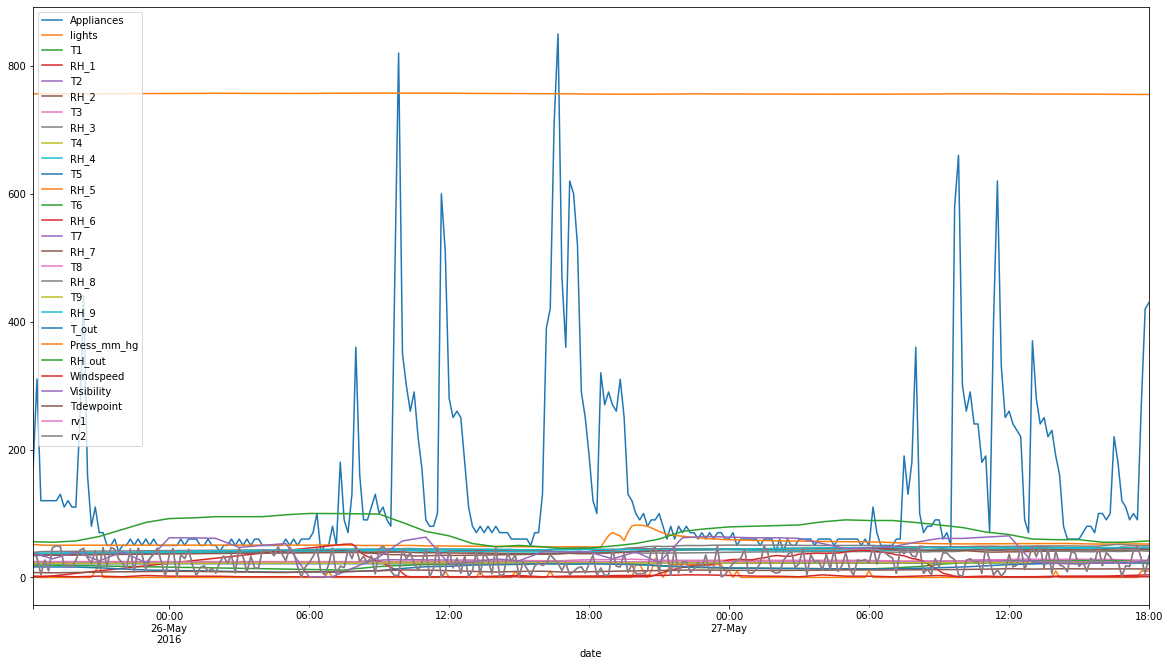

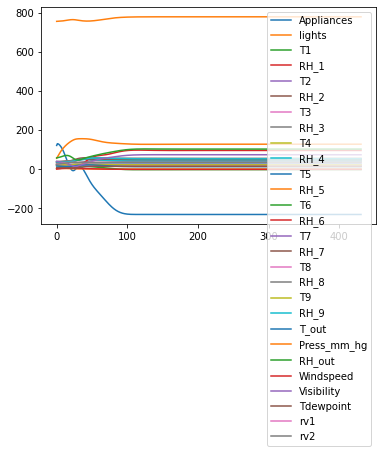

In [ ]:
test.plot(figsize=(20,11))
true_predictions.plot()